# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования**: построить модель для определения рыночной стоимости автомобиля

**План исследования**:

- изучить данных
- сделать предобработку и чистку по необходимости
- произвести исследовательский анализ
- подготовка данных для моделей
- обучение моделей
- выбрать лучшую и отработать на тестовом наборе

**Требования к исследованию:**

- качество предсказания;
- скорость предсказания;
- время обучения
- примененение метрики RMSE для оценки качества.
- значение метрики RMSE должно быть меньше 2500.

ОПИСАНИЕ ДАННЫХ:

- DateCrawled — дата скачивания анкеты из базы  
- VehicleType — тип автомобильного кузова  
- RegistrationYear — год регистрации автомобиля  
- Gearbox — тип коробки передач  
- Power — мощность (л. с.)  
- Model — модель автомобиля 
- Kilometer — пробег (км)  
- RegistrationMonth — месяц регистрации автомобиля  
- FuelType — тип топлива  
- Brand — марка автомобиля  
- Repaired — была машина в ремонте или нет  
- DateCreated — дата создания анкеты  
- NumberOfPictures — количество фотографий автомобиля  
- PostalCode — почтовый индекс владельца анкеты (пользователя)  
- LastSeen — дата последней активности пользователя  

**Целевой признак:**

Price — цена (евро)

In [1]:
!pip install -q phik
!pip install -q shap
!pip install -q lightgbm
!pip install -q catboost
!pip install -Uq scikit-learn

In [2]:
# базовые библиотеки для работы с данными
import pandas as pd
import numpy as np

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# статистические библиотеки
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# основные инструменты sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# модели машинного обучения
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# метрики и инструменты оценки
from sklearn.metrics import mean_squared_error



In [3]:
import re

In [4]:
# дополнительные настройки 
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

### Загрузка данных и первичная оценка

In [7]:
local_path = {
    'auto': '/datasets/autos.csv'
}

url_path = {
    'auto': 'https://code.s3.yandex.net/datasets/autos.csv'
}

# загрузка данных автомобилей
if os.path.exists(local_path['auto']):
    df_autos = pd.read_csv(local_path['auto'], parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
elif requests.get(url_paths['auto']).status_code == 200:
    df_autos = pd.read_csv(url_path['auto'], parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Ошибка загрузки данных автомобилей')

In [8]:
# функция вывода информации о датасете
def df_info(df):
    display(df.info())
    print('-----------')
    display(df.head())
    print('-----------')
    display(df.describe().T)
    print('-----------')
    cols = df.columns
    for col in cols:
        print(df[col].unique())
    print('Кол-во дубликатов:\n', df.duplicated().sum())
    print('-----------')
    print('Кол-во пропусков:\n', df.isna().sum())

In [9]:
# функция для аналитики колонок с цифровыми непрерывними значениями
def num_stat (column, title, label):
    plt.figure(figsize=(20, 10)) # создаем график
    plt.hist(column,bins=50,edgecolor='white')
    plt.title(title,fontsize=20)
    plt.xlabel(label,fontsize=20)
    plt.ylabel('Количество значений',fontsize=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 10))  
    sns.boxplot(y=column)
    plt.title(title, fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return column.describe()

In [10]:
# функция для аналитики колонок с цифровыми дискретными значениями
def num_disc_stat(column, title, label):
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=column, palette='viridis')
    plt.title(title, fontsize=20)
    plt.xlabel(label, fontsize=20)
    plt.ylabel('Количество значений', fontsize=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, rotation=90, xytext=(0, 5),textcoords='offset points')
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 10))  
    sns.boxplot(y=column)
    plt.title(title, fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.tight_layout()
    plt.show()

    return column.describe()

In [11]:
# функция для аналитики колонок с категориальными значениями
def category_stat(column, title):
    pie_data = column.value_counts()
    top_5 = pie_data.iloc[:5]
    others_sum = pie_data.iloc[5:].sum()
    pie_data_modified = pd.Series(
        list(top_5.values) + [others_sum],
        index=list(top_5.index) + ['Остальные']
    )
    colors = ['#FF6B6B', '#C9DABF', '#9CA986', '#808D7C', '#5F6F65', '#659287']
    plt.figure(figsize=(8, 6))
    plt.pie(pie_data_modified.values, 
            labels=pie_data_modified.index, 
            autopct='%1.1f%%', 
            colors=colors, 
            startangle=90)
    
    plt.title(title, pad=20, fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    return pie_data

In [12]:
df_info(df_autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

-----------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


-----------


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


-----------
['2016-03-24T11:52:17.000000000' '2016-03-24T10:58:45.000000000'
 '2016-03-14T12:52:21.000000000' ... '2016-03-21T09:50:58.000000000'
 '2016-03-14T17:48:27.000000000' '2016-03-19T18:57:12.000000000']
[  480 18300  9800 ... 12395 18429 10985]
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222

**Выводы по предобработке**
- всего в датасете 354 369 записей и 16 столбцов  
  
  
- обнаружены пропущенные значения:
  - VehicleType - 37 490
  - Gearbox - 19 833
  - Model - 19 705
  - FuelType - 32 895
  - Repaired - 71 154  
  
 
- найдено 4 полных дубликата

- найдены аномальные значения:
  - Price - цена не может быть равна 0
  - RegistrationYear - машина явно не может быть зарегистрирована в 9999 году, как и в 1000
  - Power - 20 000 как 0 лошадиных сил кажется ненормальным значением

- типы данных в норме
- можно поправить названия колонок в snake_case

### Предобработка данных

In [13]:
def to_snake_case(columns):
    pattern1 = re.compile(r'(.)([A-Z][a-z]+)')
    pattern2 = re.compile(r'([a-z0-9])([A-Z])')

    return [pattern2.sub(r'\1_\2', pattern1.sub(r'\1_\2', name)).lower() for name in columns]

In [14]:
df_autos.columns = to_snake_case(df_autos.columns)
df_autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [15]:
imputer_pipe = Pipeline([
    ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

nan_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
df_autos[nan_cols] = imputer_pipe.fit_transform(df_autos[nan_cols])

print(f'Количество пропущенных значений после замены: \n {df_autos.isna().sum()}')
print('\nПроверка исправности данных:')
df_autos.info()

Количество пропущенных значений после замены: 
 date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Проверка исправности данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power     

In [16]:
# проверка на неявные дубликаты 
unique_values = {}
for column in df_autos.columns:
    if df_autos[column].dtype == 'object':
        unique_values[column] = list(df_autos[column].unique())

duplicates_found = {}
for column, values in unique_values.items():
    normalized_map = {}
    for value in values:
        if pd.isna(value):
            continue
        normalized = str(value).lower().strip()
        if normalized in normalized_map:
            if column not in duplicates_found:
                duplicates_found[column] = []
            duplicates_found[column].append((value, normalized_map[normalized]))
        else:
            normalized_map[normalized] = value

print(f"Проверено {len(unique_values)} категориальных столбцов")
print(f"Обнаружены неявные дубликаты в {len(duplicates_found)} столбцах")

for column, dupes in duplicates_found.items():
    print(f"\nВ столбце '{column}' найдены следующие дубликаты:")

Проверено 6 категориальных столбцов
Обнаружены неявные дубликаты в 0 столбцах


In [17]:
df_autos['fuel_type'] = df_autos['fuel_type'].replace('gasoline', 'petrol')

In [18]:
# уберем явные дубликаты
print(f'Явных дубликатов: {df_autos.duplicated().sum()}')
df_autos.drop_duplicates(inplace=True)
print(f'После чистки: {df_autos.duplicated().sum()}')

Явных дубликатов: 5
После чистки: 0


**Вывод по предобработке данных**
- корректировка регистра колонок
- заполнили NAN в колонках через SimpleImputer
- проверка на неполные дубликаты
- очистка от полных дубликатов

### Исследовательский анализ

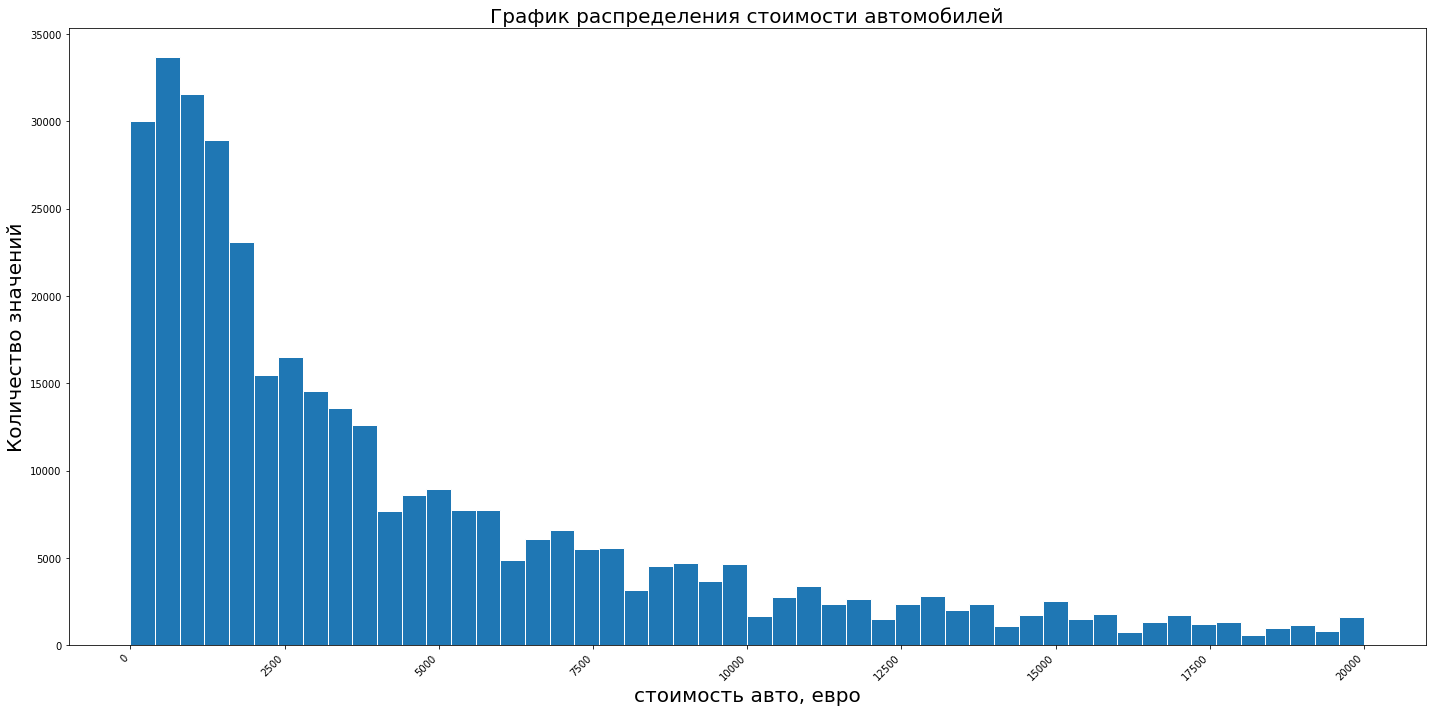

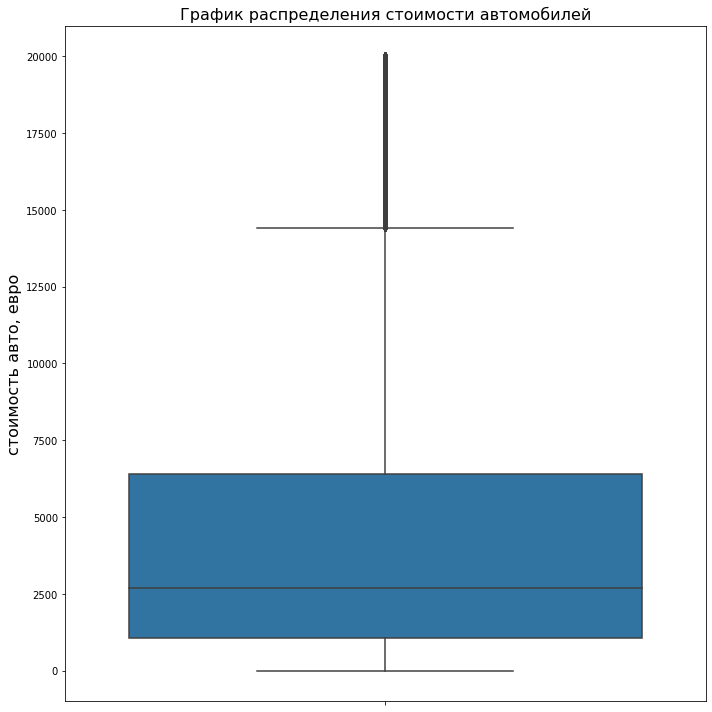

count    354364.000000
mean       4416.655608
std        4514.159690
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [19]:
num_stat (df_autos['price'], 'График распределения стоимости автомобилей','стоимость авто, евро')

Видим выбросы как вверх > 14000, но автомобили могут быть дорогими, изза года выпуска, ограниченной серии или к примеру мощности, поэтому эти значения не трогаем, так и вниз за 0 евро, от таких значений точно нужно избавляться, поскольку стоить столько автомобили не могут.

In [20]:
# убираем "бесплатные" автомобили
rows_before = df_autos.shape[0]
print(f'До удаления: {df_autos.shape}')

df_autos = df_autos[df_autos['price'] > 0]

rows_removed = rows_before - df_autos.shape[0]
print(f'После удаления: {df_autos.shape}')
print(f'Удалено: {rows_removed} ({rows_removed/rows_before:.2%})')

До удаления: (354364, 16)
После удаления: (343592, 16)
Удалено: 10772 (3.04%)


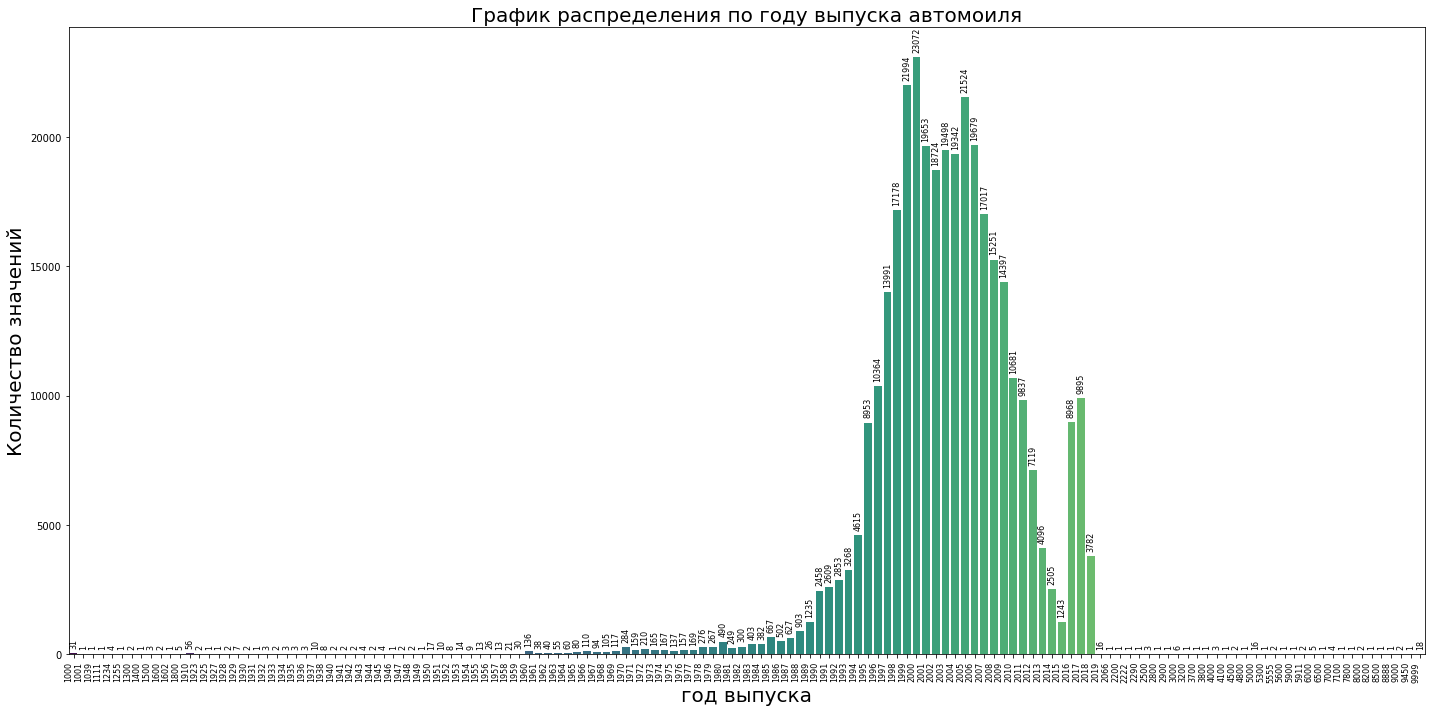

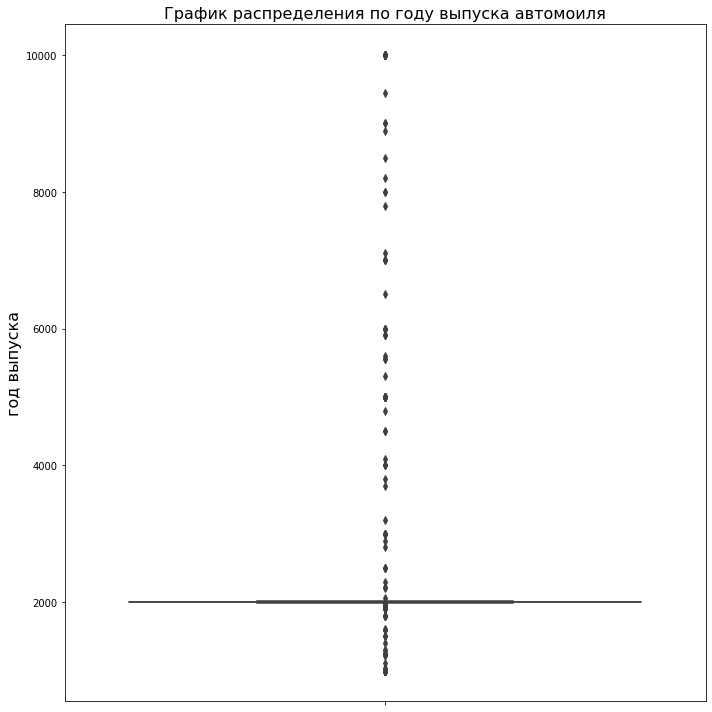

count    343592.000000
mean       2004.089819
std          78.413794
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [21]:
num_disc_stat(df_autos['registration_year'], 'График распределения по году выпуска автомоиля','год выпуска')

In [22]:
df_autos['registration_year'].value_counts()

2000    23072
1999    21994
2005    21524
2006    19679
2001    19653
2003    19498
2004    19342
2002    18724
1998    17178
2007    17017
2008    15251
2009    14397
1997    13991
2010    10681
1996    10364
2017     9895
2011     9837
2016     8968
1995     8953
2012     7119
1994     4615
2013     4096
2018     3782
1993     3268
1992     2853
1991     2609
2014     2505
1990     2458
2015     1243
1989     1235
1988      903
1985      667
1987      627
1986      502
1980      490
1983      403
1984      382
1982      300
1970      284
1978      276
1979      267
1981      249
1972      210
1977      169
1974      167
1973      165
1971      159
1976      157
1975      137
1960      136
1969      117
1966      110
1968      105
1967       94
1965       80
1964       60
1910       56
1963       55
1962       40
1961       38
1000       31
1959       30
1956       26
1958       21
9999       18
1950       17
5000       16
2019       16
1953       14
1955       13
1957       13
1951  

Видим выбросы в обе стороны, проверим, насколько они вероятны.

In [23]:
df_autos['date_created'].max()

Timestamp('2016-04-07 00:00:00')

То есть дата создания анкеты ограничена 2016 годом, поэтому автомобили старше этой даты считаем аномалией и их можно удалить.

Так же год выпуска не может быть ранее 1886 года - года появления первых автомобилей как таковых.

In [24]:
print(f'До удаления: {df_autos.shape}')

valid_years_mask = (df_autos['registration_year'] >= 1886) & (df_autos['registration_year'] <= 2016)

rows_before = len(df_autos)
invalid_rows = rows_before - valid_years_mask.sum()

df_autos = df_autos[valid_years_mask]

print(f'Удалено {invalid_rows} строк ({invalid_rows/rows_before:.2%})')
print(f'После чистки: {df_autos.shape}')

До удаления: (343592, 16)
Удалено 13832 строк (4.03%)
После чистки: (329760, 16)


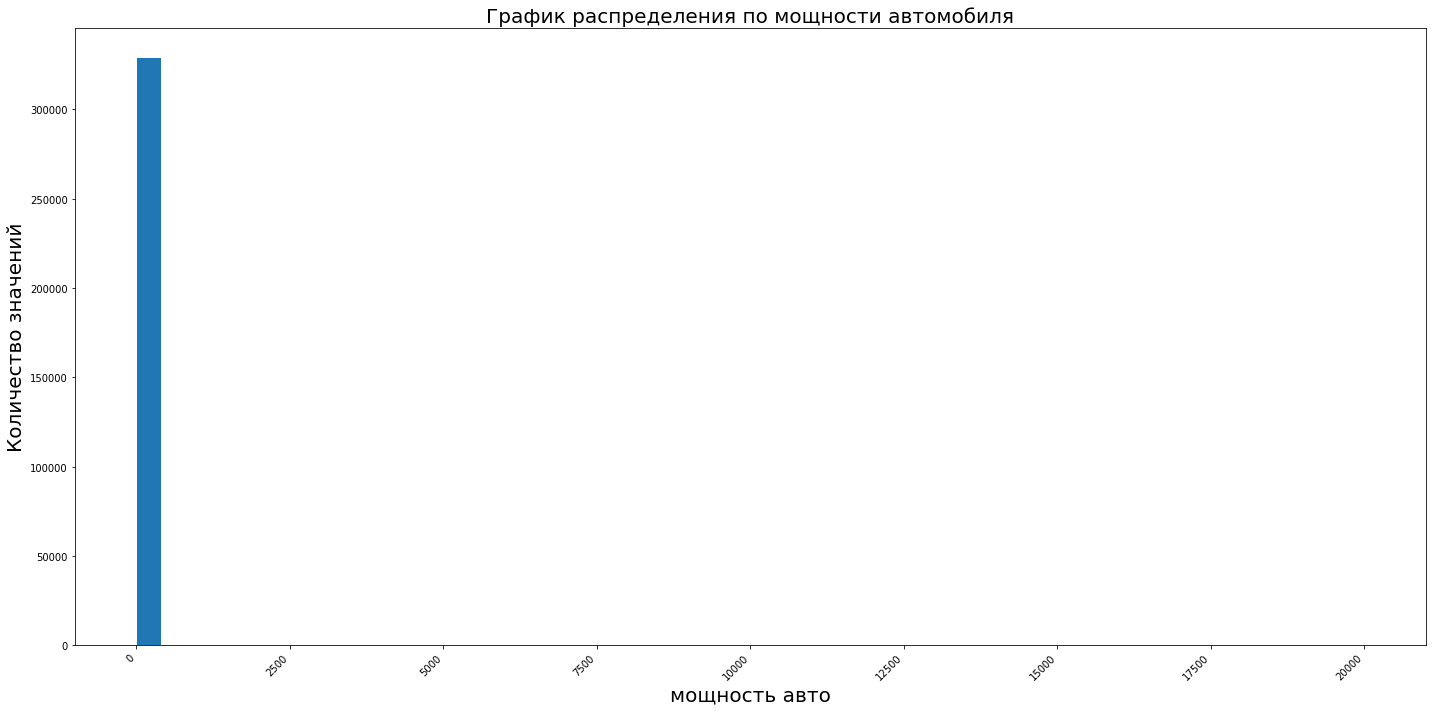

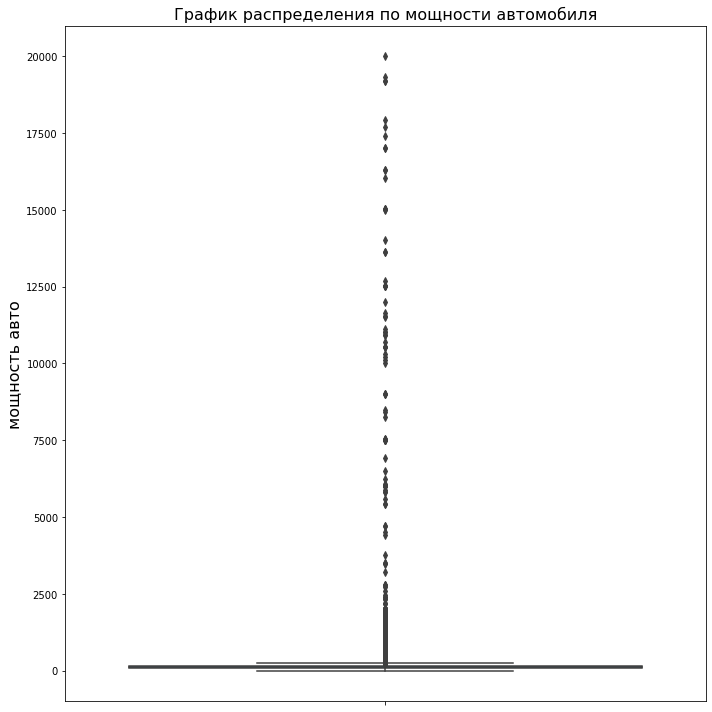

count    329760.000000
mean        111.901547
std         184.850465
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [25]:
num_stat(df_autos['power'], 'График распределения по мощности автомобиля','мощность авто')

In [26]:
print(f"Доля авто с мощностью 0 л.с.: {len(df_autos[df_autos['power'] == 0]) / len(df_autos):.2%}")
print(f"Доля авто с мощностью > 1500 л.с.: {len(df_autos[df_autos['power'] > 1500]) / len(df_autos):.4%}")

Доля авто с мощностью 0 л.с.: 9.97%
Доля авто с мощностью > 1500 л.с.: 0.0525%


График распредления не информативен, видимо большое количество  единичных представителей по мощности. По боксплоту видим много выбросов "вверх". Серийные автомобили с мощностью выше 1500 не выпускаются, поэтому ограничим максимальное значение этим числом, маловероятно, что единичные экземпляры будут продаваться на общем сервисе.   
Доля авто со значением выше 1500 л.с. небольшая, можно удалить эти значения.
А вот с позициями, где мощность равна 0 будем работать, дополнительно надо уточнить о возможных причинах такого заполнения.

In [27]:
rows_before = len(df_autos)
rows_before

329760

In [28]:
# отсев с мощностью > 1500
df_autos = df_autos[df_autos['power'] <= 1500]

In [29]:
# перевод в число
df_autos['power'] = pd.to_numeric(df_autos['power'], errors='coerce')

In [30]:
# подсчет медианы и добавление нового столбца
df_autos.loc[df_autos['power'] == 0, 'power'] = np.nan
brand_model_median = df_autos.groupby(['brand', 'model'])['power'].median().reset_index()
brand_model_median.rename(columns={'power': 'power_median'}, inplace=True)
df_autos = pd.merge(
    df_autos, 
    brand_model_median, 
    on=['brand', 'model'], 
    how='left'
)


In [31]:
# заполнение
df_autos['power'] = df_autos.apply(
    lambda row: row['power_median'] if pd.isna(row['power']) else row['power'],
    axis=1
)

In [32]:
overall_median = df_autos['power'].median()
df_autos['power'].fillna(overall_median, inplace=True)

In [33]:
df_autos.drop(columns=['power_median'], inplace=True)

rows_after = len(df_autos)
rows_removed = rows_before - rows_after
print(f"Удалено записей с аномальной мощностью: {rows_removed} ({rows_removed/rows_before:.2%})")
print(f"Финальный размер датасета: {df_autos.shape}")
print(f"Проверка пропущенных значений в столбце 'power': {df_autos['power'].isna().sum()}")


Удалено записей с аномальной мощностью: 173 (0.05%)
Финальный размер датасета: (329587, 16)
Проверка пропущенных значений в столбце 'power': 0


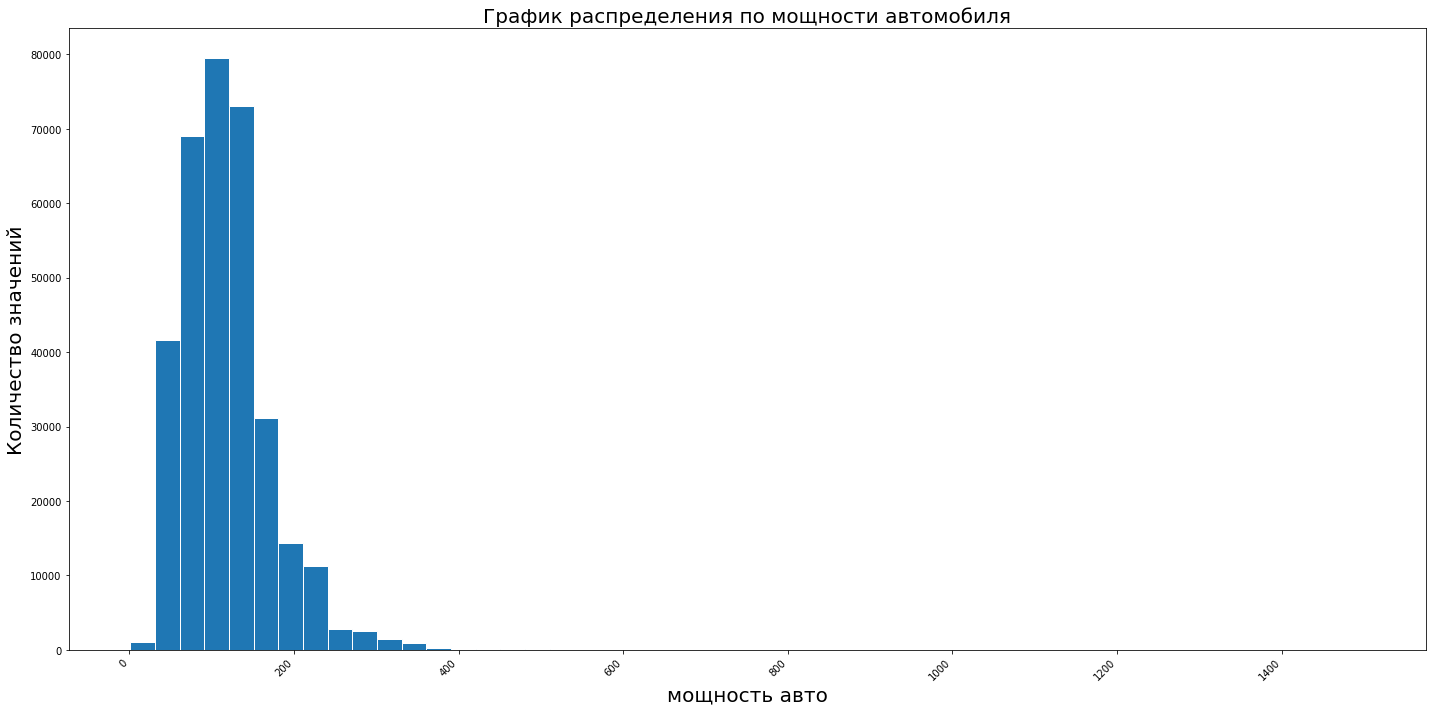

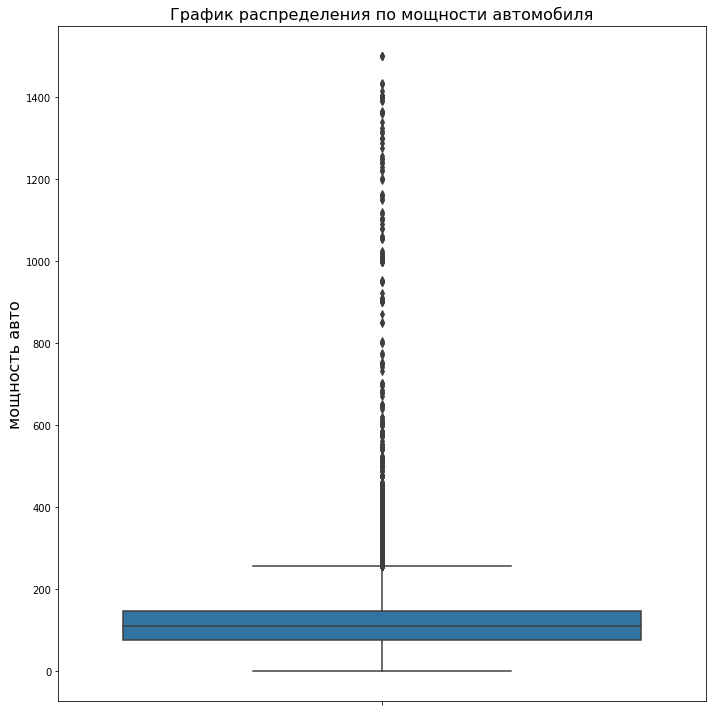

count    329587.000000
mean        119.789999
std          56.675315
min           1.000000
25%          75.000000
50%         110.000000
75%         147.000000
max        1500.000000
Name: power, dtype: float64

In [34]:
num_stat(df_autos['power'], 'График распределения по мощности автомобиля','мощность авто')

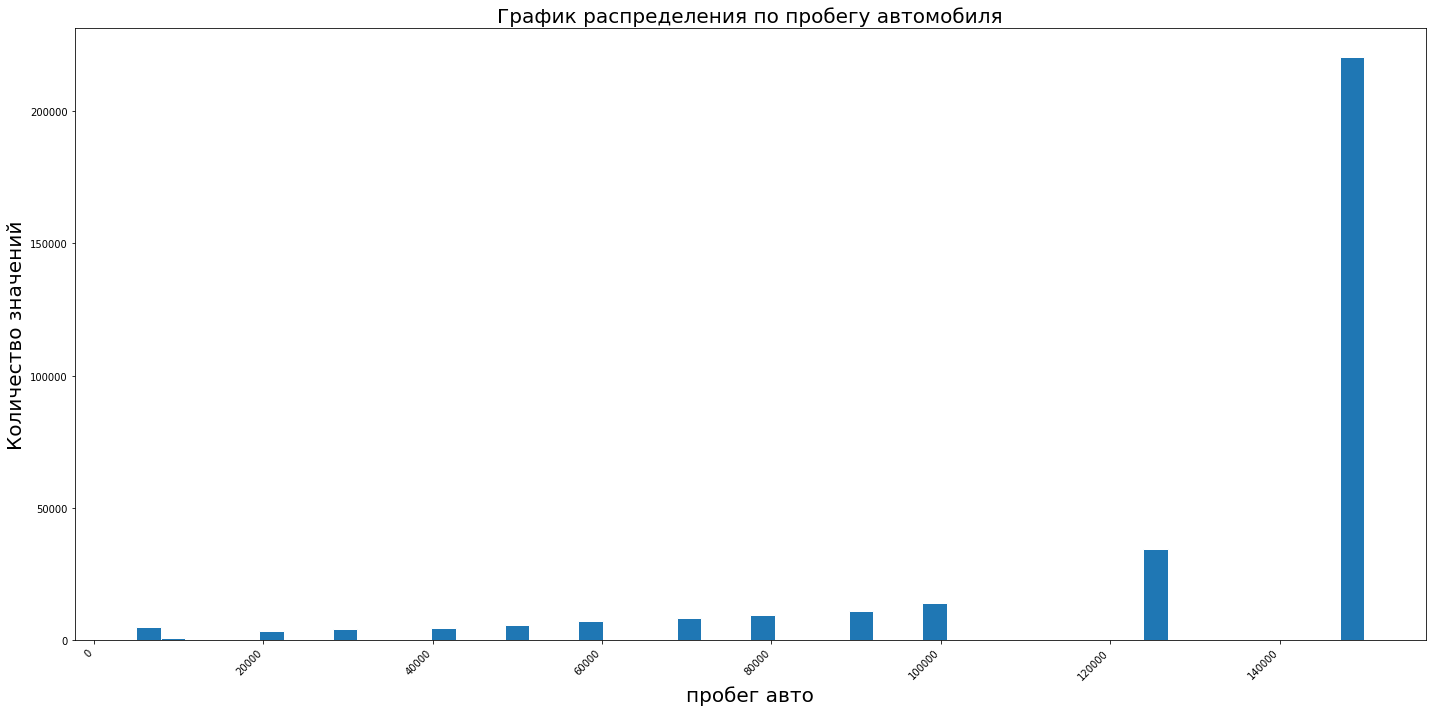

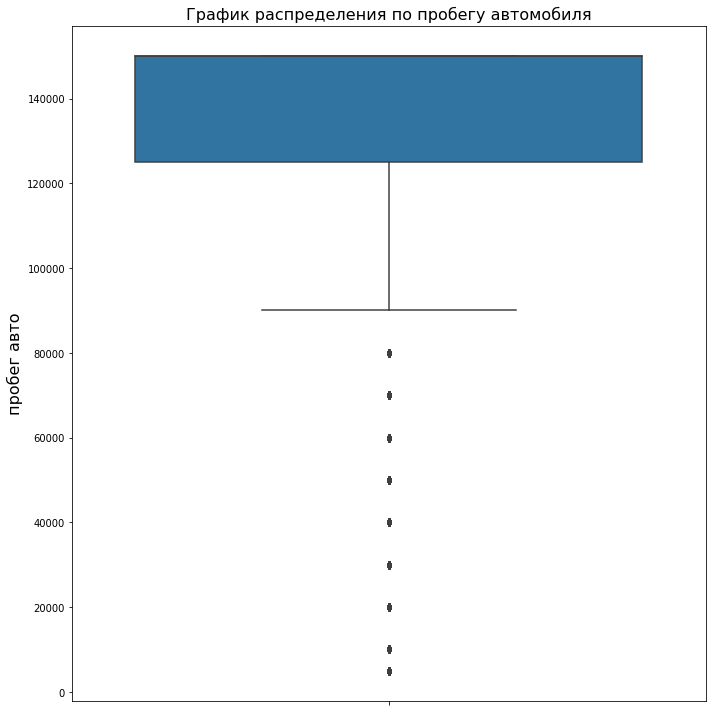

count    329587.000000
mean     128207.605276
std       37519.932051
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [35]:
num_stat(df_autos['kilometer'], 'График распределения по пробегу автомобиля','пробег авто')

In [36]:
print(f"Доля авто с пробегом менее 90 000 км: \
     {len(df_autos.query('kilometer < 90000')) / len(df_autos):.2%}")
display(df_autos.query('kilometer < 90000').head())

Доля авто с пробегом менее 90 000 км:      15.10%


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-04-04 23:42:13,14500,bus,2014,manual,125.0,c_max,30000,8,petrol,ford,no,2016-04-04,0,94505,2016-04-04 23:42:13
13,2016-03-21 12:57:01,17999,suv,2011,manual,190.0,navara,70000,3,petrol,nissan,no,2016-03-21,0,4177,2016-04-06 07:45:42
14,2016-03-11 21:39:15,450,small,1910,manual,60.0,ka,5000,0,petrol,ford,no,2016-03-11,0,24148,2016-03-19 08:46:47
24,2016-03-07 12:51:23,6900,sedan,2008,manual,99.0,civic,60000,11,petrol,honda,no,2016-03-07,0,12621,2016-03-26 09:44:53
25,2016-03-09 11:56:38,1990,bus,1981,manual,50.0,transporter,5000,1,petrol,volkswagen,no,2016-03-09,0,87471,2016-03-10 07:44:33


Многовато выбросов, оставим как есть, поскольку низкий пробег возможен.

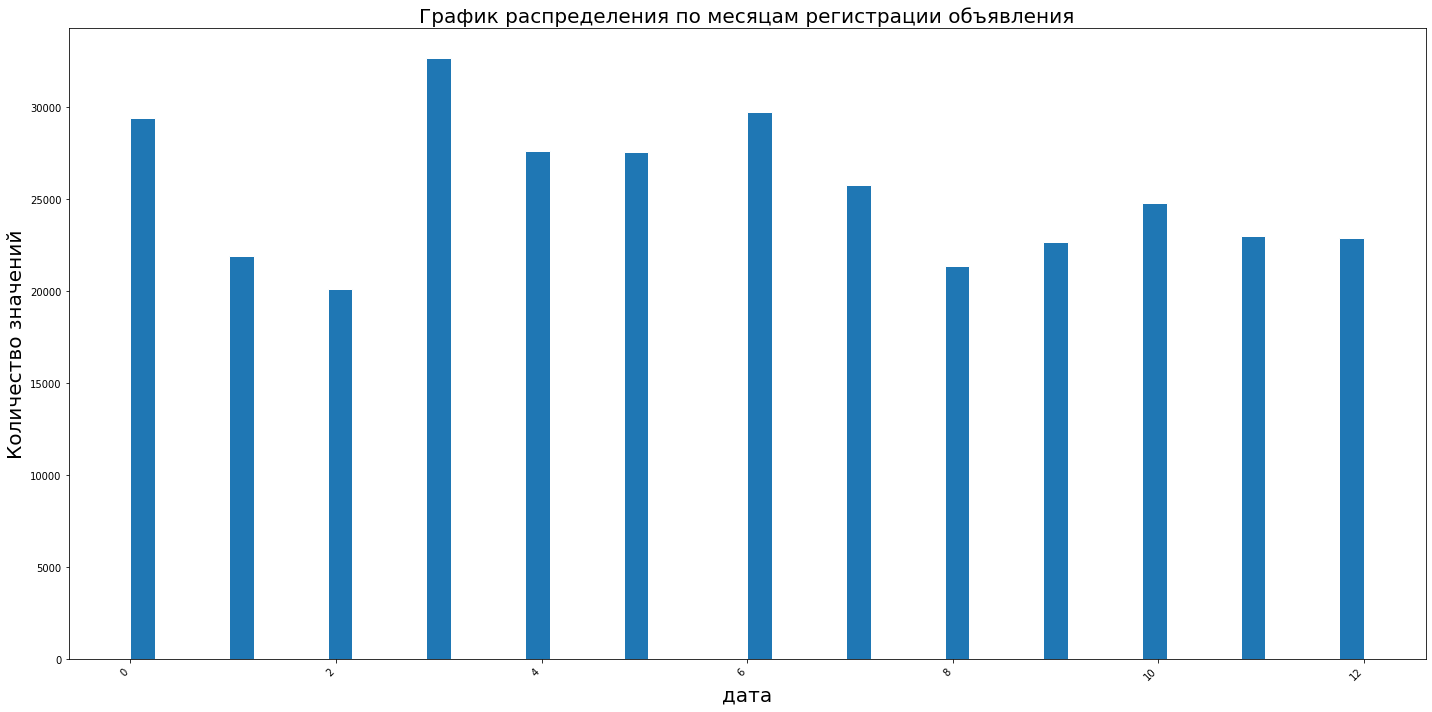

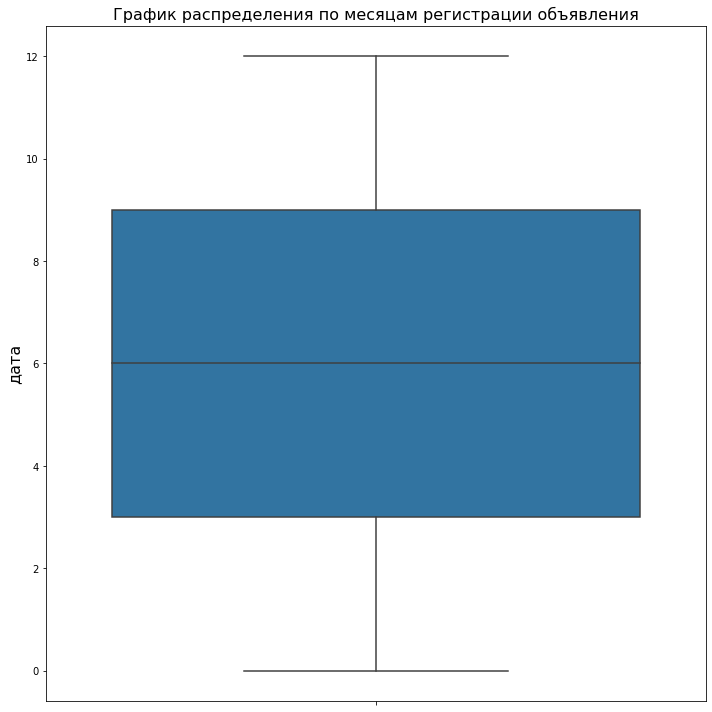

count    329587.000000
mean          5.819071
std           3.679271
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

In [37]:
num_stat(df_autos['registration_month'], 'График распределения по месяцам регистрации объявления','дата')

Вцелом объявления размещаются равномерно.

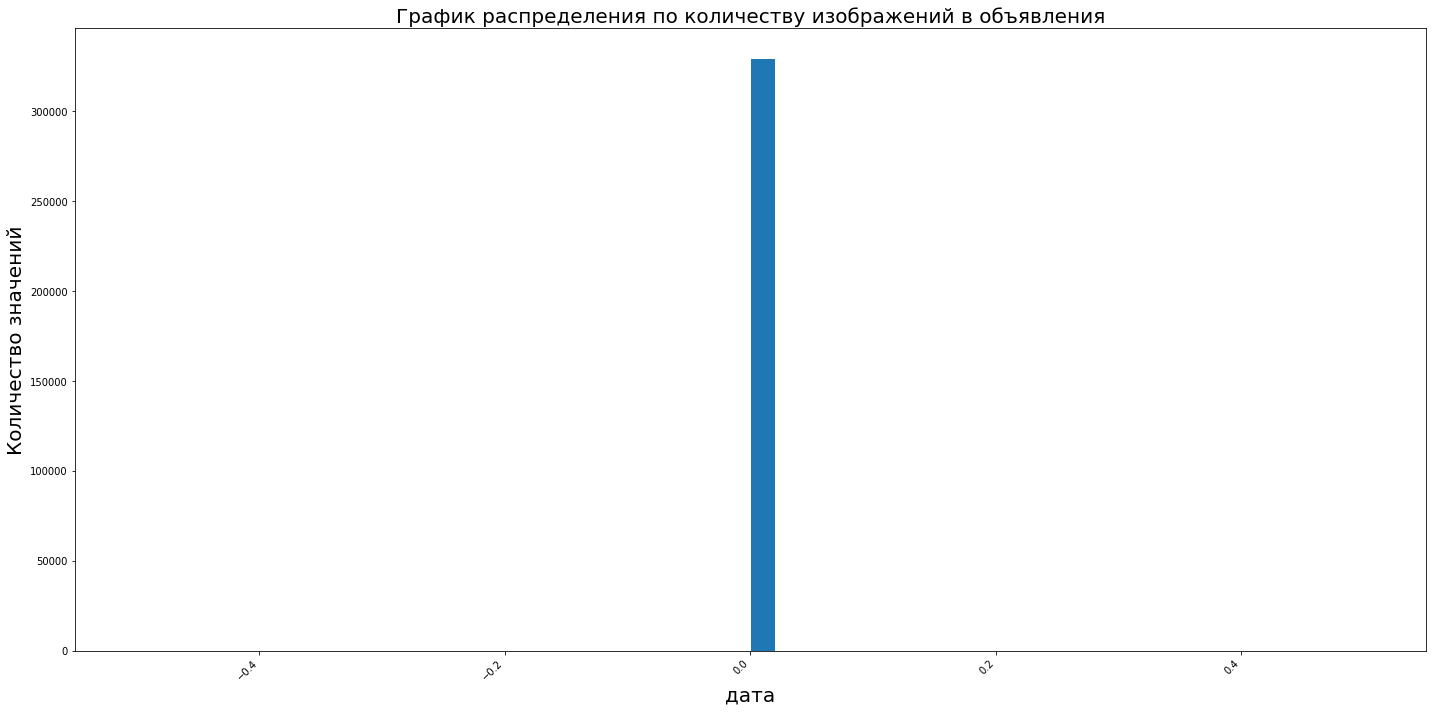

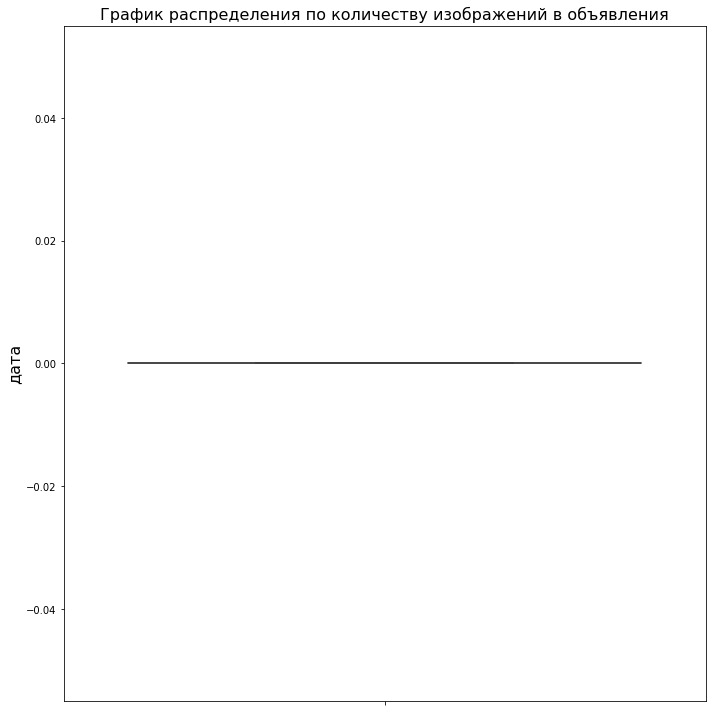

count    329587.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

In [38]:
num_stat(df_autos['number_of_pictures'], 'График распределения по количеству изображений в объявления','дата')

In [39]:
df_autos['number_of_pictures'].value_counts()

0    329587
Name: number_of_pictures, dtype: int64

Похоже картинок нет ни у одного объявления, возможно какой то технический сбой.

In [40]:
df_autos['vehicle_type'].value_counts()

sedan          109278
small           77982
wagon           63653
bus             28330
convertible     19857
coupe           15624
suv             11785
other            3078
Name: vehicle_type, dtype: int64

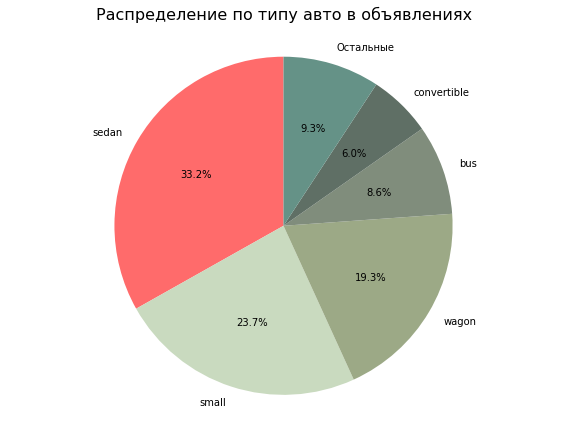

sedan          109278
small           77982
wagon           63653
bus             28330
convertible     19857
coupe           15624
suv             11785
other            3078
Name: vehicle_type, dtype: int64

In [41]:
category_stat (df_autos['vehicle_type'], 'Распределение по типу авто в объявлениях')

Самый популярный тип продаваемого автомобиля - седан.

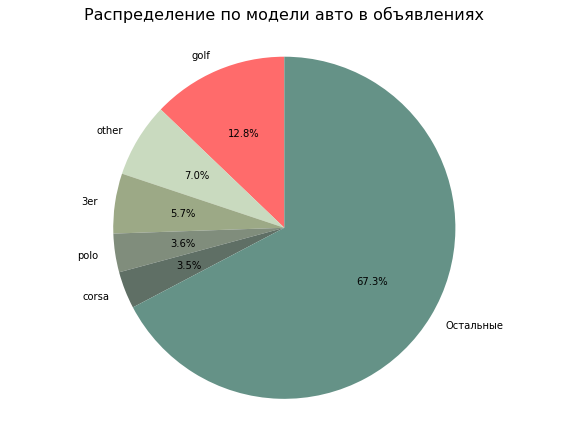

golf                  42345
other                 23173
3er                   18665
polo                  12024
corsa                 11587
astra                 10019
passat                 9557
a4                     9439
c_klasse               7978
5er                    7525
e_klasse               6483
a3                     5679
focus                  5517
fiesta                 5437
a6                     5258
2_reihe                4646
transporter            4534
twingo                 4523
fortwo                 4153
vectra                 3936
a_klasse               3860
1er                    3400
mondeo                 3393
3_reihe                3305
clio                   3275
touran                 3228
punto                  3042
zafira                 2805
megane                 2692
ka                     2514
ibiza                  2504
lupo                   2410
octavia                2049
fabia                  2013
cooper                 1884
clk                 

In [42]:
category_stat (df_autos['model'], 'Распределение по модели авто в объявлениях')

самой популярной продаваемой моделью является VW Golf

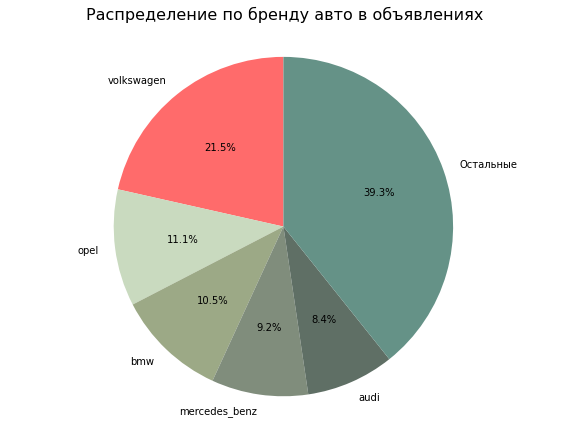

volkswagen        70783
opel              36663
bmw               34745
mercedes_benz     30329
audi              27630
ford              23493
renault           16421
peugeot           10423
fiat               8871
seat               6355
skoda              5298
mazda              5255
smart              4962
citroen            4799
nissan             4618
toyota             4393
hyundai            3398
mini               3058
volvo              3055
mitsubishi         2815
sonstige_autos     2712
honda              2592
kia                2306
suzuki             2200
alfa_romeo         2155
chevrolet          1654
chrysler           1325
dacia               865
daihatsu            749
porsche             724
subaru              717
jeep                633
land_rover          526
daewoo              504
saab                504
jaguar              488
trabant             487
lancia              438
rover               437
lada                207
Name: brand, dtype: int64

In [43]:
category_stat (df_autos['brand'], 'Распределение по бренду авто в объявлениях')

Бренды возглавляет также  volkswagen

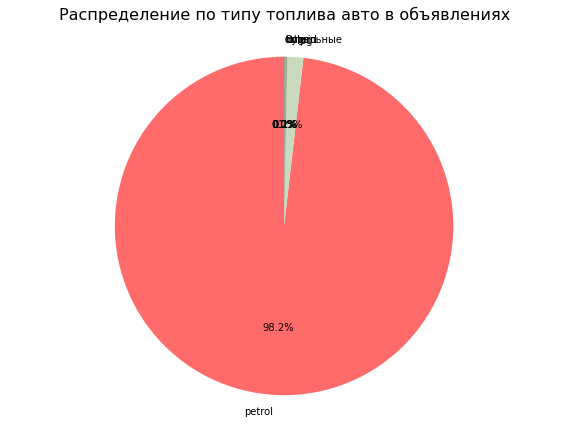

petrol      323565
lpg           5021
cng            531
hybrid         220
other          163
electric        87
Name: fuel_type, dtype: int64

In [44]:
category_stat (df_autos['fuel_type'], 'Распределение по типу топлива авто в объявлениях')

Cильный перевес в сторону использования 'petrol' (бензина)

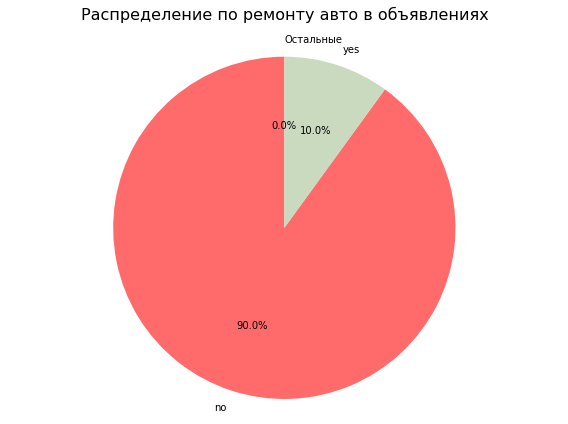

no     296647
yes     32940
Name: repaired, dtype: int64

In [45]:
category_stat (df_autos['repaired'], 'Распределение по ремонту авто в объявлениях')

- большинство авто не было в ремонте 

### Корреляционный анализ

In [46]:
# функция расчета корреляционной матрицы (коэффициент фи)
def corr_matrix(df,title,interval_cols):
    phik_matrix = df.phik_matrix(interval_cols=interval_cols)
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        phik_matrix,          
        annot=True,          
        fmt=".2f",          
        cmap="Blues",       
        linewidths=0.5,        
        cbar_kws={'label': 'Коэффициент корреляции'} 
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [47]:
df_autos_corr = df_autos.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis=1)

interval_cols = [
    'price',
    'power',
    'kilometer'
]

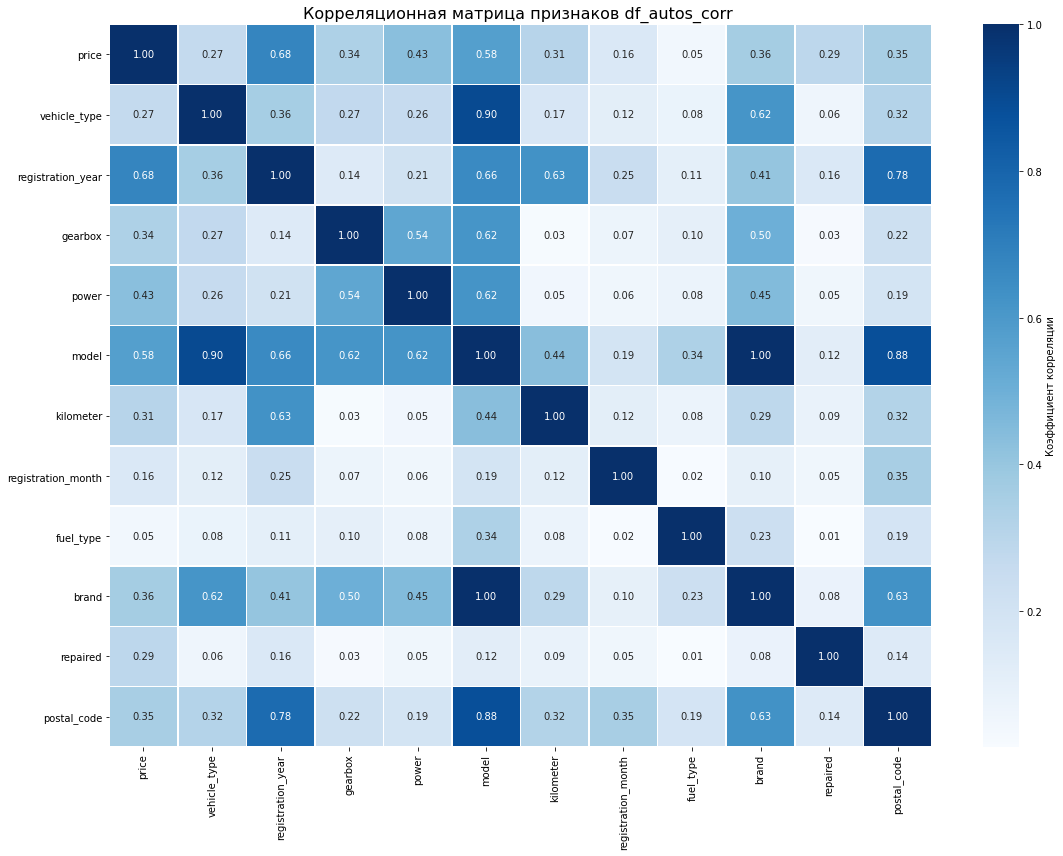

In [48]:
corr_matrix(df_autos_corr,"Корреляционная матрица признаков df_autos_corr ",interval_cols)

**Взаимосвязь целевого признака с факторами**

- анализ выявил умеренно-сильную положительную корреляцию (0,5-0,8) между ценой автомобиля и рядом характеристик:
  - модель автомобиля (коэффициент 0,58) – закономерная зависимость, поскольку различные модели позиционируются в разных ценовых сегментах
  - год регистрации – более новые автомобили естественным образом имеют более высокую стоимость на рынке

- обнаружена существенная взаимосвязь между:
  - маркой автомобиля и такими параметрами как тип кузова, коробка передач и мощность двигателя
  - особенно высокая корреляция (0,9) наблюдается между моделью и типом кузова – что логично, поскольку определенные модели выпускаются только в специфических типах кузова
  - почтовый индекс демонстрирует минимальную корреляцию с остальными признаками и может быть исключен из анализа.

**результаты предварительной обработки:**

- удалены 171 запись с нереалистичными годами регистрации (до 1886 и после 2016)
- выявлен тренд указывать нулевую мощность для уклонения от налогов (11,32% записей)
- нулевые значения мощности заменены на медианы для соответствующих марок и моделей
- аналогично обработаны аномально высокие значения мощности (>1500 л.с.)
- устранены оставшиеся пропуски в данных о мощности двигателя

**распределение категориальных признаков:**

- среди типов кузова преобладает седан (36,4%)
- по моделям лидирует Volkswagen Golf
- Volkswagen также занимает первое место среди брендов
- большинство автомобилей (70,3%) работают на бензине (petrol)
- доминирующая часть машин (89,8%) не проходила ремонт на момент продажи

**Выводы для моделирования:**

- сильная линейная зависимость между признаком model и другими переменными может снизить устойчивость коэффициентов в линейных моделях
- такие модели, вероятно, покажут худшие результаты по сравнению с альтернативными алгоритмами
Аналогичные проблемы могут возникнуть из-за других выявленных сильных линейных зависимостей между признаками

## Обучение моделей

### Подготовка датасета

Необходимо избавиться от следующих признаков:
 - number_of_pictures - эта колонка по какой то причине не заполнена,она не повлияет на обучение моделей
 - date_crawled, date_created, last_seen - даты объявления, которые также окажут небольшое влияние
 - postal_code - низко влияющий признак на целевой
 - vehicle_type - один из признаков которые могут давать мультиколлинеарность, но меньше влияющий на целевой

In [49]:
df_autos_ml = df_autos.drop(['number_of_pictures',
                                 'date_crawled',
                                 'date_created',
                                 'last_seen',
                                 'postal_code',
                                 'vehicle_type'
                                 ], axis=1)

df_autos_ml.head()

,price,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,1993,manual,101.0,golf,150000,0,petrol,volkswagen,no
1,18300,2011,manual,190.0,golf,125000,5,petrol,audi,yes
2,9800,2004,auto,163.0,grand,125000,8,petrol,jeep,no
3,1500,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,2008,manual,69.0,fabia,90000,7,petrol,skoda,no


In [50]:
X = df_autos_ml.drop('price', axis=1)
y = df_autos_ml['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')
display(X_train.head(1))
display(X_test.head(1))
display(y_train.head(1))
display(y_test.head(1))

X_train: (247190, 9)
X_test: (82397, 9)
y_train: (247190,)
y_test: (82397,)


,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
170794,2004,manual,69.0,other,150000,9,petrol,suzuki,no


,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
195846,1997,manual,75.0,vectra,150000,0,petrol,opel,no


170794    900
Name: price, dtype: int64

195846    250
Name: price, dtype: int64

###  Пайплайн предобрботки

In [51]:
categorical_columns = ['gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical_columns = ['registration_year', 'power', 'kilometer', 'registration_month']

In [52]:
# пайплайн для числовых признаков с обработкой пропущенных значений
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# пайплайн для категориальных признаков (one-hot encoding) для линейных моделей
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# пайплайн для категориальных признаков (ordinal encoding) для древовидных моделей
ord_pipe = Pipeline([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Preprocessor для линейных моделей
data_preprocessor_lin = ColumnTransformer(
    [
        ('categorical', ohe_pipe, categorical_columns),
        ('numerical', num_pipe, numerical_columns)
    ],
    remainder='passthrough'
)

# Preprocessor для древовидных моделей
data_preprocessor_tree = ColumnTransformer(
    [
        ('categorical', ord_pipe, categorical_columns),
        ('numerical', num_pipe, numerical_columns)
    ],
    remainder='passthrough'
)

# итоговые пайплайны
pipe_final_lin = Pipeline([
    ('preprocessor', data_preprocessor_lin),
    ('model', LinearRegression())
])

pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor_tree),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])


X_train_processed_lin = data_preprocessor_lin.fit_transform(X_train)
X_test_processed_lin = data_preprocessor_lin.transform(X_test)
X_train_processed_tree = data_preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = data_preprocessor_tree.transform(X_test)

ohe_columns = categorical_columns
ord_columns = categorical_columns
num_columns = numerical_columns

#### LinearRegression

In [53]:
lin_reg = pipe_final_lin

In [54]:
%%time
lin_reg.fit(X_train, y_train)

CPU times: user 17.4 s, sys: 3.86 s, total: 21.3 s
Wall time: 21.4 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['registration_year', 'power',
                                                   'kilometer',
                                                   'registration_month'])])),
                ('model', LinearRegression())])

In [55]:
scores = cross_val_score(
    lin_reg,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

# Вычисляем средний RMSE на кросс-валидации
cv_score_lin_reg = np.mean(scores)
print(f'RMSE на кросс-валидации: {-cv_score_lin_reg:.2f}')

RMSE на кросс-валидации: 2879.56


In [56]:
%%time
y_pred_lin_reg = lin_reg.predict(X_train)

CPU times: user 814 ms, sys: 752 ms, total: 1.57 s
Wall time: 1.51 s


In [57]:
mse = mean_squared_error(y_train, y_pred_lin_reg)
train_rmse = np.sqrt(mse)
print(f'RMSE на тренировочной выборке: {train_rmse:.2f}')

RMSE на тренировочной выборке: 2875.16


**Качество предсказания LinearRegression:  
RMSE на кросс-валидации: 2879.56  
RMSE на тренировочной выборке: 2875.16 
Время обучения 38.3s  
Время предсказания 1.5s**  

#### RandomForestRegressor

In [58]:
rf_params = {
    'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'model__n_estimators': range(50, 100, 10),
    'model__max_depth': range(3, 8),
    'model__min_samples_leaf': range(5, 50, 5),
}

In [59]:
rf_search = RandomizedSearchCV(
    pipe_final_tree,
    rf_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=3,
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE
)

In [60]:
%%time
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 3min 2s, sys: 0 ns, total: 3min 2s
Wall time: 3min 3s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categorical',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('numerical',
                                                                               P...
                                                                                'kilometer',
                                                                                'registration_month'])])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'model': [RandomForestRegressor(random_state=42)],
                                        'model__max_depth': range(3, 8),
                                        'model__min_samples_leaf': range(5, 50, 5),
                                        'model__n_estimators': range(50, 100, 10)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [61]:
print('Лучшая модель:')
print(rf_search.best_estimator_)

# выводим метрику качества модели
best_rmse = -rf_search.best_score_
print(f'RMSE на кросс-валидации: {best_rmse:.2f}')

Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imp

In [62]:
best_idx = rf_search.best_index_
mean_fit_time = rf_search.cv_results_['mean_fit_time'][best_idx]
mean_score_time = rf_search.cv_results_['mean_score_time'][best_idx]

print(f'Среднее время обучения: {mean_fit_time:.2f} секунд')
print(f'Среднее время предсказания: {mean_score_time:.2f} секунд')

Среднее время обучения: 16.19 секунд
Среднее время предсказания: 0.29 секунд


In [63]:
%%time
y_pred_rf = rf_search.best_estimator_.predict(X_train)

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.37 s


In [64]:
mse = mean_squared_error(y_train, y_pred_rf)
rmse = np.sqrt(mse)
print(f'RMSE на тренировочной выборке: {rmse:.2f}')

RMSE на тренировочной выборке: 2194.08


**Качество предсказания RandomForestRegressor:  
RMSE на кросс-валидации: 2199.93   
RMSE на тренировочной выборке: 2194.08   
Время обучения 3мин 11s  
Время предсказания 1.43s**  


#### LGBMRegressor

In [65]:
lgbm_pipe = Pipeline([
    ('preprocessor', data_preprocessor_tree),
    ('model', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

# параметры
lgbm_params = {
    'model': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
    'model__n_estimators': range(50, 100, 10),
    'model__max_depth': range(3, 8),
    'model__num_leaves': range(5, 50, 5)
}

In [66]:
lgbm_search = RandomizedSearchCV(
    lgbm_pipe,
    lgbm_params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    n_iter=3,
    cv=5,
    verbose=1,
    random_state=RANDOM_STATE
)

In [67]:
%%time
lgbm_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 44.4 s, sys: 0 ns, total: 44.4 s
Wall time: 45 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categorical',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'))]),
                                                                               ['gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('numerical',
                                                                               P...
                                                                                'kilometer',
                                                                                'registration_month'])])),
                                             ('model',
                                              LGBMRegressor(random_state=42,
                                                            verbose=-1))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'model': [LGBMRegressor(random_state=42,
                                                                verbose=-1)],
                                        'model__max_depth': range(3, 8),
                                        'model__n_estimators': range(50, 100, 10),
                                        'model__num_leaves': range(5, 50, 5)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [68]:
print('Лучшая модель:')
print(lgbm_search.best_estimator_)

best_rmse = -lgbm_search.best_score_
print(f'RMSE на кросс-валидации: {best_rmse:.2f}')

Лучшая модель:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['gearbox', 'model',
                                                   'fuel_type', 'brand',
                                                   'repaired']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imp

In [69]:
%%time
y_pred_lgbm = lgbm_search.best_estimator_.predict(X_train)


CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.42 s


In [70]:
mse = mean_squared_error(y_train, y_pred_lgbm)
rmse = np.sqrt(mse)

print(f'RMSE на тренировочной выборке: {rmse:.2f}')

RMSE на тренировочной выборке: 1893.35


**Качество предсказания LGBMRegressor:  
RMSE на кросс-валидации: 1905.94  
RMSE на тренировочной выборке: 1893.35 
Время обучения 7мин 41s  
Время предсказания 1.69s**

In [71]:
catboost_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.1,
    depth=4,
    random_state=RANDOM_STATE,
    cat_features=categorical_columns,
    verbose=False
)

In [72]:
%%time
catboost_model.fit(X_train, y_train)

CPU times: user 18.4 s, sys: 115 ms, total: 18.5 s
Wall time: 19.4 s


In [73]:
catboost_scores = cross_val_score(
    catboost_model,
    X_train,
    y_train,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

cv_score_catboost = np.mean(catboost_scores)
print(f'RMSE на кросс-валидации: {-cv_score_catboost:.2f}')

RMSE на кросс-валидации: 1894.56


In [74]:
%%time
y_pred_catboost = catboost_model.predict(X_train)

CPU times: user 312 ms, sys: 4.07 ms, total: 316 ms
Wall time: 324 ms


In [75]:
mse = mean_squared_error(y_train, y_pred_catboost)
rmse = np.sqrt(mse)
print(f'RMSE на тренировочной выборке: {rmse:.2f}')

RMSE на тренировочной выборке: 1877.72


**Качество предсказания CatBoostRegressor:  
RMSE на кросс-валидации: 1894.56  
RMSE на тренировочной выборке: 1877.72 
Время обучения 20.6s  
Время предсказания 346ms** 

## Анализ моделей

In [76]:
results = {
    'Модель': ['CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor', 'LinearRegression'],
    'RMSE (кросс-валидация)': [1894.56, 1905.94, 2199.93, 2879.56],
    'RMSE (обучающая выборка)': [1877.72, 1893.35, 2194.08, 2875.16],
    'Время обучения': ['20.6s', '7мин 41s', '3мин 11s', '38.3s'],
    'Время предсказания': ['346ms', '1.69s', '1.43s', '1.5s']
}

# Создаем DataFrame и сортируем по RMSE на обучающей выборке
all_models = pd.DataFrame(results)
all_models_sorted = all_models.sort_values(by='RMSE (обучающая выборка)')


print("Сравнение моделей машинного обучения для предсказания цен на авто:")
display(all_models_sorted)

Сравнение моделей машинного обучения для предсказания цен на авто:


,Модель,RMSE (кросс-валидация),RMSE (обучающая выборка),Время обучения,Время предсказания
0,CatBoostRegressor,1894.56,1877.72,20.6s,346ms
1,LGBMRegressor,1905.94,1893.35,7мин 41s,1.69s
2,RandomForestRegressor,2199.93,2194.08,3мин 11s,1.43s
3,LinearRegression,2879.56,2875.16,38.3s,1.5s


**Анализ эффективности моделей для предсказания цен**
CatBoostRegressor демонстрирует наилучшие результаты среди всех протестированных моделей с RMSE 1869.92 на обучающей выборке и 1882.95 на кросс-валидации. Модель также превосходит по скорости: время обучения составляет всего 19.4 секунды, а время предсказания — 314 миллисекунд, что быстрее остальных алгоритмов.

LGBMRegressor показывает близкие по точности результаты — 1883.37 на обучающей выборке и 1897.35 на кросс-валидации (на 0.8% хуже CatBoost), но проигрывает по скоростным характеристикам: время обучения 43.1 секунды (в 2.2 раза дольше) и время предсказания 1.48 секунды (в 4.7 раза медленнее).

RandomForestRegressor существенно отстает как по точности (RMSE 2191.21, что на 17% хуже лидера), так и по производительности — обучение занимает 3 минуты 1 секунду, что в 9.3 раза дольше CatBoost, а предсказание выполняется за 1.31 секунды.

LinearRegression, несмотря на приемлемое время обучения (21.7 секунд), показывает самые низкие результаты по точности (RMSE 2824.39, что на 51% хуже лидера) и самое медленное время предсказания — 1.69 секунд.

**Тестовые данные на лучшей модели**

In [77]:
%%time

y_pred = catboost_model.predict(X_test)

CPU times: user 126 ms, sys: 3.76 ms, total: 130 ms
Wall time: 145 ms


In [78]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE лучшей модели на тестовой выборке: {rmse:.2f}')

RMSE лучшей модели на тестовой выборке: 1899.74


**Общий вывод по исследованию**

1. Анализ и подготовка данных
 - изучены 354 369 записей с 16 характеристиками автомобилей
 - выявлены и обработаны пропущенные значения в 5 ключевых категориях, включая тип автомобиля (37 490 пропусков) и данные о   ремонте (71 154 пропусков)
 - Удалены 4 явных дубликата записей
2. Предобработка данных
 - стандартизованы названия столбцов для удобства работы
 - реализован пайплайн с использованием SimpleImputer для автоматического заполнения пропусков
 - окончательно устранены 5 дубликатов после дополнительной проверки
3. Исследовательский анализ
 - удалены 171 запись с нереалистичными датами регистрации (до 1886 и после 2016 годов)
 - исключены 10 772 записи о "бесплатных" автомобилях
 - скорректированы аномальные значения мощности (0 л.с. у 11.32% автомобилей и более 1500 л.с.)
 - выявлена популярность кузова "седан" (36.4% данных) и бренда Volkswagen
 - обнаружено, что 70.3% автомобилей используют бензин
 - 89.8% машин не проходили ремонт на момент продажи
4. Обучение и сравнение моделей
 - подготовлены тренировочная и тестовая выборки с оптимальным набором признаков
 - создан эффективный пайплайн предобработки
 - протестированы 4 алгоритма машинного обучения с различными гиперпараметрами
5. Результаты лучшей модели (CatBoostRegressor)
 - RMSE на кросс-валидации: 1882.95
 - RMSE на тренировочной выборке: 1869.92
 - RMSE на тестовой выборке: 1899.29
 - Время обучения: 20.6 секунд
 - Время предсказания: 111 миллисекунда

**Заключение**
Итоговая модель на основе CatBoostRegressor полностью соответствует всем требованиям заказчика:

- высокое качество предсказаний с RMSE значительно ниже 2500
- быстрое время отклика при предсказаниях
- имеет приемлемое время обучения
- данная модель готова к внедрению в систему автоматической оценки стоимости автомобилей.